In [1]:
import imf
import numpy as np
from scipy import stats
from scipy.stats import rv_continuous
from scipy import special
from sympy import lowergamma
from scipy import integrate
from sympy.utilities.lambdify import lambdify
import mpmath

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [129]:
# Create a function that returns the PDF of the Schechter function
# Empirical virgo-cluster dE distribution taken from 
# Sanchez-Janssen 2016, ApJ 820, 69 doi:10.3847/0004-637X/820/1/69
# Normalize PDF via numerical integral (it was pretty close to normalized to begin with)
# While it's not necessary to add the _cdf routine, it speeds up the rvs draws by a huge factor
class Schechter(rv_continuous):
    def __init__(self,alpha,mstar,mmin=1.e5,**args):
        self.mmin = mmin
        self.mmax = 1.e13
        self.alpha = alpha
        self.mstar = mstar
        super(Schechter,self).__init__(a=self.mmin,b=self.mmax,**args)
        self.integral = mpmath.fp.gammainc(-self.alpha+1.,self.mmin/self.mstar,self.mmax/self.mstar)
    def _pdf(self,m):
        x = m/self.mstar
        return (x)**-self.alpha * np.exp(-x) / self.integral
    def _cdf(self,m):
        if type(m) == type(np.array([0])):
            arr = [mpmath.fp.gammainc(-self.alpha+1.,self.mmin/self.mstar,x) for x in m/self.mstar]
            return np.array(arr)/self.integral
        else:
            return mpmath.fp.gammainc(-self.alpha+1.,self.mmin/self.mstar,m/self.mstar)/self.integral

In [134]:
mf = Schechter(1.3,3.e10)
mf.mmin/mf.mstar
mf.integral,mf.cdf(1.e13)

(142.23324533663333, 1.0)

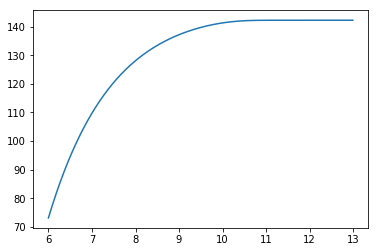

In [108]:
mf = Schechter(1.3,3.e10)
logm=np.arange(6,13,0.01)
m = 10.**logm
#mf.cdf(m)
plt.plot(logm,mf.cdf(m))

In [109]:
mf = Schechter(1.3,3.e10)
mf.pdf(1.e9)

0.5659525602979332

In [184]:
logm=np.arange(5,13,0.1)
m = 10.**logm
n = 1.e-4 * mf.pdf(m)
m

array([1.00000000e+05, 1.25892541e+05, 1.58489319e+05, 1.99526231e+05,
       2.51188643e+05, 3.16227766e+05, 3.98107171e+05, 5.01187234e+05,
       6.30957344e+05, 7.94328235e+05, 1.00000000e+06, 1.25892541e+06,
       1.58489319e+06, 1.99526231e+06, 2.51188643e+06, 3.16227766e+06,
       3.98107171e+06, 5.01187234e+06, 6.30957344e+06, 7.94328235e+06,
       1.00000000e+07, 1.25892541e+07, 1.58489319e+07, 1.99526231e+07,
       2.51188643e+07, 3.16227766e+07, 3.98107171e+07, 5.01187234e+07,
       6.30957344e+07, 7.94328235e+07, 1.00000000e+08, 1.25892541e+08,
       1.58489319e+08, 1.99526231e+08, 2.51188643e+08, 3.16227766e+08,
       3.98107171e+08, 5.01187234e+08, 6.30957344e+08, 7.94328235e+08,
       1.00000000e+09, 1.25892541e+09, 1.58489319e+09, 1.99526231e+09,
       2.51188643e+09, 3.16227766e+09, 3.98107171e+09, 5.01187234e+09,
       6.30957344e+09, 7.94328235e+09, 1.00000000e+10, 1.25892541e+10,
       1.58489319e+10, 1.99526231e+10, 2.51188643e+10, 3.16227766e+10,
      

(5, 11)

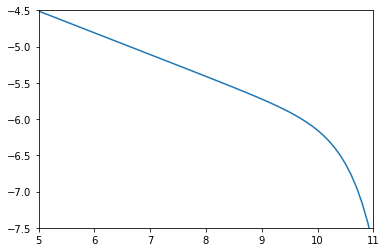

In [186]:
plt.plot(logm,np.log10(n*(m/mf.mstar)))
plt.ylim(-7.5,-4.5)
plt.xlim(5,11)

In [139]:
masses = mf.rvs(size=10000)

(5, 11)

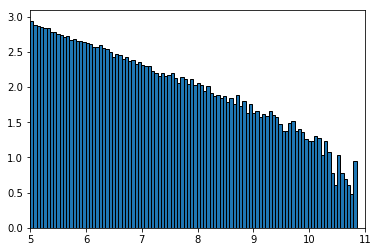

In [183]:
logm = np.log10(masses)
dndlogm,edges = np.histogram(logm,100)
plt.bar(edges[:-1], np.log10(dndlogm), width=np.diff(edges), ec="k", align="edge")
plt.xlim(5,11)

In [45]:
len(edges)

11

In [21]:
from sympy import uppergamma, lowergamma, symbols, lambdify

In [35]:
expr=lowergamma(-0.3,40.)-lowergamma(-0.3,3.33e-7)
expr.evalf()

288.186394895080

In [36]:
result = mpmath.fp.gammainc(-0.3,3.33e-7,40.)
result

288.1863948950803

In [29]:
special.gammainc(-0.3,4)-special.gammainc(-0.3,0.0001)

nan

In [20]:
x = symbols('x')
expr=lowergamma(-0.3,x)-lowergamma(-0.3,0.1)
expr
func = lambdify(x, expr,'numpy')
m = np.arange(0.2,5.,0.1)
func(m)

NameError: name 'lowergamma' is not defined

In [59]:
imf.make_cluster(10,massfunc='schechter',beta=1.3,m0=1.,mmin=0.01)

AttributeError: 'function' object has no attribute 'mmin'

In [18]:
result

6.396830235796179

In [187]:
import numpy as np
def simulate_schechter_distribution(alpha, M_star, M_min, N):
    """ 
        Adapted from https://gist.github.com/joezuntz/5056136
        Based on algorithm in http://www.math.leidenuniv.nl/~gill/teaching/astro/stanSchechter.pdf
    """
    n=0
    output = []
    while n<N:
        M = np.random.gamma(scale=M_star, shape=alpha+2, size=N)
        M = M[M>M_min]
        u = np.random.uniform(size=M.size)
        M = M[u<M_min/M]
        output.append(M)
        n+=M.size
    return np.concatenate(output)[:N]

In [188]:
masses = simulate_schechter_distribution(-1.3,3.e10,1.e5,20000)

/Users/hcferguson/anaconda3/envs/astroconda36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


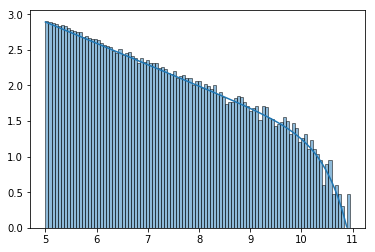

In [189]:
logm = np.log10(masses)
dndlogm,edges = np.histogram(logm,100)
plt.bar(edges[:-1], np.log10(dndlogm), width=np.diff(edges), ec="k", align="edge",alpha=0.5)
mf = Schechter(1.3,3.e10,mmin=1.e5)
n = mf.pdf(10.**edges[:-1])
plt.plot(edges[:-1],np.log10(20000.*n*10**edges[:-1]/3.e10)-0.9)
#n

In [190]:
len(masses)

20000